In [43]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from subprocess import call
from IPython.display import display, clear_output
from PIL import Image
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.4.1


In [70]:
model_name = './17 may/17_may'

In [71]:
json_file = open(model_name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [72]:
loaded_model = model_from_json(loaded_model_json)


In [73]:
loaded_model.load_weights(model_name+".h5")


In [24]:
from helper import *

In [25]:
GRID_SIZE = 4
def convert_to_grid(arr):
  n = np.argmax(arr)
  # print(arr)
  # return 'row '+str(n%grid_size)+', col '+str(n//grid_size)
  return [n//GRID_SIZE, n%GRID_SIZE]

In [74]:
HEATMAP = [0 for _ in range(GRID_SIZE**2)]

In [10]:
def start_heatmap():
    HEATMAP = [0 for _ in range(GRID_SIZE**2)]

In [11]:
def generate_heatmap():
    print(HEATMAP)
    S = sum(HEATMAP)
    print(S)
    img = Image.new(mode='L', size=(960,540))
#     for i in range(10,100):
#         for j in range(50,200):
#             img.putpixel((i,j),255)
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            num = row*GRID_SIZE + col
            val = HEATMAP[num]
            
            for i in range((col*960)//GRID_SIZE, ((col+1)*960)//GRID_SIZE):
                for j in range((row*540)//GRID_SIZE, ((row+1)*540)//GRID_SIZE):
                    img.putpixel((i,j),int(val*255/S))
    return img

In [12]:
def confusion_matrix():
    S = sum(HEATMAP)
    print(HEATMAP,S)
    arr = [h*100/S for h in HEATMAP ]
    df_cm = pd.DataFrame(np.array(arr).reshape(-1,GRID_SIZE), index = [i+1 for i in range(GRID_SIZE)],
                  columns = [i+1 for i in range(GRID_SIZE)])
    plt.figure(figsize = (19,11))
    sn.heatmap(df_cm, annot=True)

In [13]:
def test_model(roix=(250,250),roiy=(150,80),eye_size=1):
    roi_offset = [roix[0],roiy[0]]

    while True:
        _,frame = cam.read()
        frame = cv2.flip(frame,1)
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

        roi = gray[roi_offset[1]:roi_offset[1]+roiy[1], roi_offset[0]:roi_offset[0]+roix[1]]
        eye,_ = find_eye(roi, scale_sizes=(70,101,10))

        cv2.imshow('frame',roi)
        if eye['maxmatch'] > 0.87:
            
            resized = cv2.resize(eye['img'],(69,40))
            arr = np.asarray(resized).reshape(40,69,1)
            
            tl = eye['top_left']
            tl = [(tl[0] + roix[0]) / 848, (tl[1] + roiy[0]) / 480]
            
            pred = loaded_model.predict([[arr],[tl]])
            
        else:
            # print('no strong match')
            pass
        k = cv2.waitKey(2)
        if k == 27:
            break

    cam.release()
    cv2.destroyAllWindows()
    return

In [47]:
hist = [0 for _ in range(11)]

In [95]:
cam = cv2.VideoCapture(0)
start_heatmap()
toggle = 'off'
while True:
    _,frame = cam.read()
    frame = cv2.flip(frame,1)
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
#     gray = gray + gray
    
    roi_offset = [270,150]
    rw = 308
    rh = 100
    roi = gray[roi_offset[1]:roi_offset[1]+rh, roi_offset[0]:roi_offset[0]+rw]
    eye,pupil = find_eye(roi, scale_sizes=(80,116,15))
    
    if eye['maxmatch'] > 0.87:

        cv2.imshow('eye',eye['img'])

        resized = cv2.resize(eye['img'],(65,40))
        arr = np.asarray(resized).reshape(1,40,65,1)
        
        tl = eye['top_left']
        tl = np.array([(tl[0] + roi_offset[0]) / 848, (tl[1] + roi_offset[1]) / 480]).reshape(1,2)

        # ~~~~~~~~~~~~~~~~~~~
        pred = loaded_model.predict([arr,tl])[0]
        # ~~~~~~~~~~~~~~~~~~~

        clear_output(wait=True)
        display('capture state: '+toggle)

        am = np.argmax(pred)
        
        row,col = convert_to_grid(pred)
        wid = 1920 // GRID_SIZE
        hgt = 1080 // GRID_SIZE

        sx = int((col + 0.5) * wid)
        sy = int((row + 0.5) * hgt)
        
        conf = 100*pred[am]
        display('Prediction: '+str([row,col])+' | Confidence: '+str(conf))

        if conf >= 80:
            command = 'xdotool mousemove '+str(sx)+' '+str(sy)
            call(command,shell=True)
    
    cv2.imshow('roi',roi)
    k = cv2.waitKey(2)
    if k==27:
        break
    if k==ord(' '):
        toggle = 'off' if toggle == 'on' else 'on'
        
        
cam.release()
cv2.destroyAllWindows()

'capture state: off'

'Prediction: [2, 0] | Confidence: 99.99946355819702'

'on'

In [87]:
HEATMAP

[165, 43, 35, 56, 34, 39, 15, 9, 54, 81, 32, 41, 85, 26, 11, 77]

[165, 43, 35, 56, 34, 39, 15, 9, 54, 81, 32, 41, 85, 26, 11, 77]
803


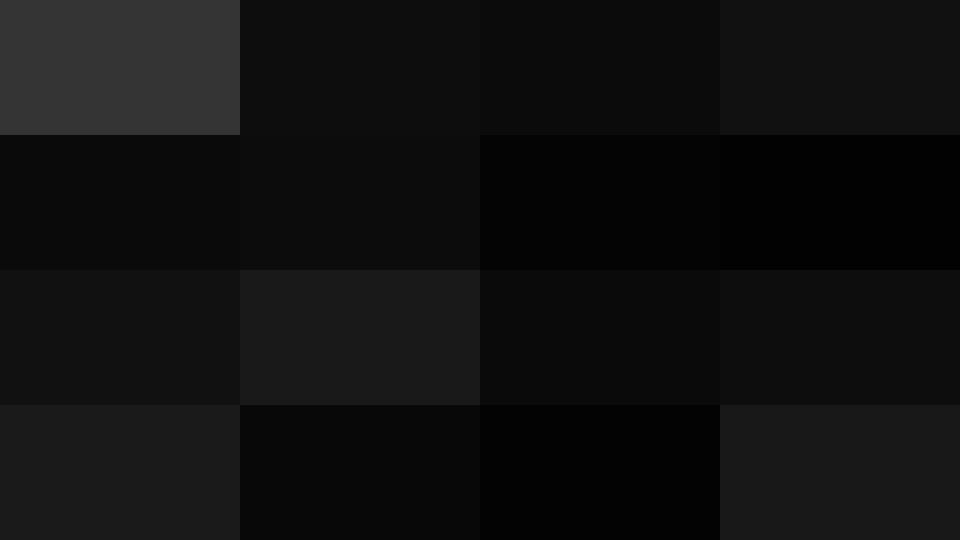

In [88]:
generate_heatmap()

[111, 84, 66, 57, 29, 94, 306, 113, 13, 117, 993, 508, 9, 47, 140, 19] 2706


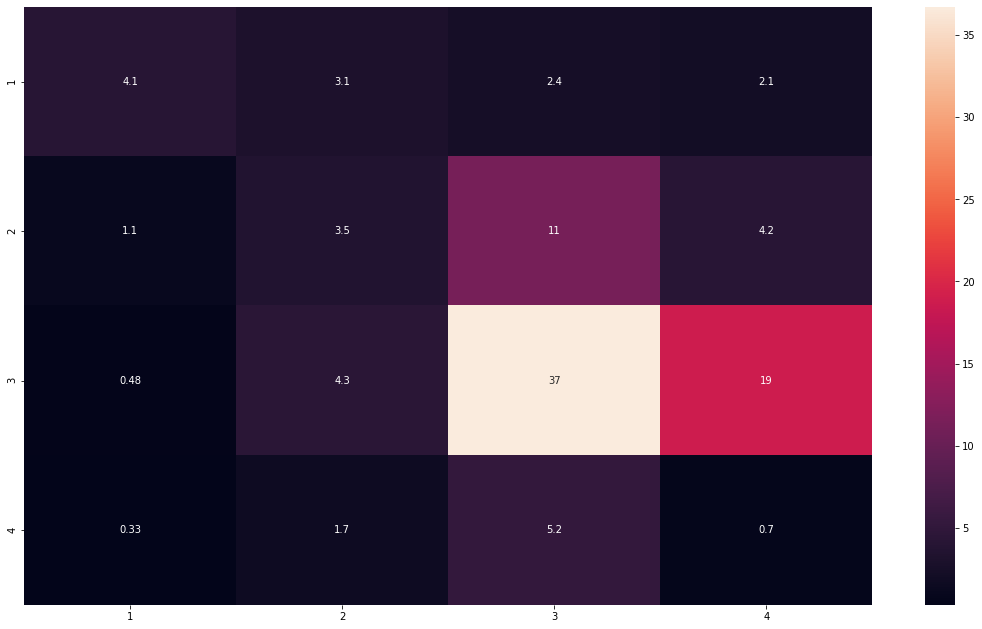

In [55]:
confusion_matrix()